# __Scenario D:__<br>Time-dependent enzyme inactivation

Data provided by Paulo Durão (Microbial & Enzyme Technology, Instituto de Tecnologia Química e Biológica, Oeiras, Portugal)

## Project background
All investigated enzyme reaction without inhibitor showed progress curves behavior, which was not explainable by irreversible Michaelis-Menten kinetics. SUBSTRATE PRODUCT INHIBITION. All experiments had in commmon, that enzyme reactions were carried out in 96-well polystyrene micro titer plates (MTP), whereas the change in substrate and or product absorption was monitored photometrically. 
One hypothesis for the observed time-dependent decrease of enzyme activity is potential hydrophobic interaction between the enzyme and the MTP suface. Thereby, hydrophobic regions of the enzyme's surface might interact with the hydrophobic reaction vessle, ultimately preventing substrate access to the active site of the enzyme.  
In order to test the hypothesis, an absorption experiment in which enzyme was incubated in MTP wells prior to reaction start was performed. Thereby, the enzyme activity should decrease with regard to the prior incubation time. If the hypothesis is correct, the calculated half life from the adsorption experiment 
should match with the half life of an enzyme kinetics experiment which was conducted in parallel.

For this experiment Co




__Show results of enzyme inactication across projects__ #TODO

All investigated enzyme reactions in this thesis showed a time-dependent decrease in catalytic activity, which was not explainable by the irreversible Michaelis-Menten model.

### Experimental design

CotA laccase from *Bacillus subtilis*
Both experiments wer conducted with CotA from 

__Determination of enzyme inactivation trough adsorption__  
In order to test the hypothesis of time-dependent enzyme inactivation through adsorption to the MTP surface, the following experiment was conducted. Thereby, enzyme solution was incubated in individual MTP wells up to 1 h, prior to reaction start.  Then, individual enzyme reactions were started in triplicates by transferring 2 µL of incubated enzyme in 10 min increments. Each proceeding enzyme reaction contained 256 nM CotA, 1 mM ABTS and was buffered in acetate buffer at pH 4. Product formation was followed photometrically at 420 nm and 25°C for 5 min, whereas concentrations were calculated assuming an extincion coefficient of ε = 36000 M<sup>-1</sup>cm<sup>-1</sup> for the ABTS radical product.

__Enzyme kinetics experiment__  
Enzymatic oxidation of ABTS to its radical form was followed photometrically at 420 nm at 25°C for 70 min. 
Thereby, ABTS was applied in a range from 0.01 mM - 2 mM. Each proceeding enzyme reaction contained 256 nM CotA, and was buffered in acetate buffer at pH 4.

### Experimantal data

Experimantal data was provided as an Excel file, containing time-course absorption data. Meta data was written into the EnzymeML Excel template. Then, the experimantal data was written to an EnzymeML document by a parser function. Concentrations were calculated via the provided extinction coefficient of the ABTS radical (ε = 36000 M<sup>-1</sup>cm<sup>-1</sup>). 

## Adsorption of enzyme to micro titer plate surface

### Imports

In [90]:
import numpy as np
import pandas as pd
from scipy.stats import linregress
import pyenzyme as pe
from EnzymePynetics.tools.parameterestimator import ParameterEstimator
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import display


#TODO warning in EnzymePynetics

import warnings
warnings.filterwarnings('ignore')

### Experimantal data

Experimental data was provided as an Excel file. Data was loaded into an pandas DataFrame and the slopes of each incubation condition were calculated through linear regression. The resulting initial rates were used to calculate by which the enzyme activity decreases in regard to the incubation time tin the reaction vessel. Lastly the half life of the enzyme was calculated with equation {eq}`enzyme_halflife`

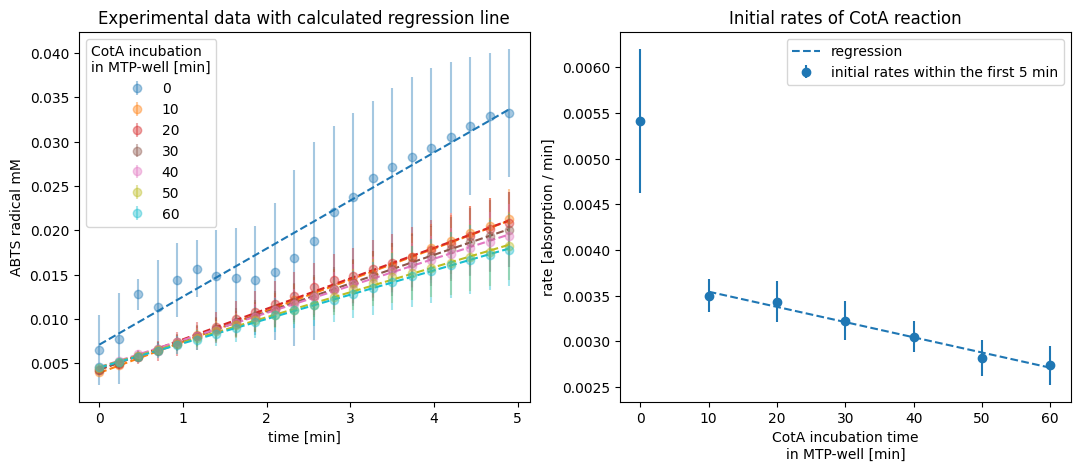

Calculated half life based on regression slope: 693.73 h


In [114]:
# Load excel
path = '../../data/enzyme_inactivation/Slide 2 - Activity effect of incubating CotA in MTP.xlsx'
df = pd.read_excel(path, sheet_name='csv').set_index('time (min)')

# replace values of '0**' with nan-values, since the measurement is incorrect
df['0**'] = np.nan



# Get data from Excel file
columns = [int(x) for x in list(df.columns) if str(x).endswith("0")]
time = df.index.values
absorption = df.values.T.reshape(7,3,22)

# Calculate concentrations
extinction_coefficient = 36 # (1/mM * 1/cm)
optical_length = 0.65 # cm

def absorption_to_concentration(abso):
    return abso / (extinction_coefficient*optical_length)

concentration = absorption_to_concentration(absorption)
concentration_mean = np.nanmean(concentration, axis = 1)
concentration_std = np.nanstd(concentration, axis = 1)

# Linear regression
slopes = []
intercepts = []
stderrs = []
for time_set in concentration:
    mask = ~np.isnan(time_set)
    time_regression = np.tile(time, 3).reshape(mask.shape)[mask].flatten()
    data_regression = time_set[mask].flatten()
    slope,intercept,_,_,stderr = (linregress(time_regression, data_regression))
    slopes.append(slope)
    intercepts.append(intercept)
    stderrs.append(stderr)

# Regression for the slopes between 10 and 60 mincolumns
slope_of_slopes, intercept_of_slopes,_,_,_ = linregress(columns[1:], slopes[1:])

# Half life in hours
t12 = (np.log(2)/-slope_of_slopes)/60

# Plot results
colors = cm.tab10(np.linspace(0, 1, len(absorption)))
fig, axes = plt.subplots(1,2, figsize=(12.8,4.8), sharey=False, sharex=False)

for mean, std, label, slope, intercept, color in zip(concentration_mean, concentration_std, columns, slopes, intercepts, colors):
    axes[0].errorbar(time, mean, std, fmt='o', label=label, alpha = 0.4, color=color)
    axes[0].plot(np.array(time), np.array(time)*slope+intercept, '--', color=color)
    axes[0].legend(title="CotA incubation\nin MTP-well [min]")
    axes[0].set_ylabel('ABTS radical mM')
    axes[0].set_xlabel('time [min]')
    axes[0].set_title('Experimental data with calculated regression line')


axes[1].errorbar(columns, slopes, stderrs, fmt='o', label="initial rates within the first 5 min")
axes[1].set_xlabel("CotA incubation time\nin MTP-well [min]")
axes[1].set_ylabel('rate [absorption / min]')
axes[1].plot(np.array(columns[1:]), slope_of_slopes*np.array(columns[1:])+intercept_of_slopes, "--", color=colors[0], label=f"regression")
axes[1].legend()
axes[1].set_title('Initial rates of CotA reaction')

plt.show()

print(f"Calculated half life based on regression slope: {t12:.2f} h")

_Fig. XXX: Experimental data regression results of CotA experiment with different enzyme incubation times._

The left plot of figure XXX shows the change in product concentration over the first 5 minutes of the enzyme reaction. Therein, different enzyme incubation times prior to reaction start are color-coded. The first reaction without prior incubation shows large standard deviations between the experimental repeats. This might be the result of insufficient mixing or inconsisten ammount of enzyme between the repeats. All other slopes showed a gradually decreasing slope for increased incubation times.  
The plot on the right of figure XXX shows the initial rates of the enzyme reactions in relation to prior enzyme incubation time. Based on the calculated initial rates, the decrease
Due to the high standard deviation between 


In [92]:
# Load experimental data from excel file
df = pd.read_excel("../../data/enzyme_inactivation/Repetition CotA ABTS kinetics higher volumes 2nd time.xlsx", sheet_name="csv").set_index("Time(min)")
data = df.values.T.reshape(8,4,72)
time = df.index.values

# Calculate concentrations
extinction_coefficient = 36 # (1/mM * 1/cm)
optical_length = 0.65 # cm

def absorption_to_concentration(abso):
    return abso / (extinction_coefficient*optical_length)

concentration_data = absorption_to_concentration(data)

# Parser function
def data_to_EnzymeML(
    template_path: str,
    measurement_data: np.ndarray,
    species_id: str,
    data_unit: str,
    time_unit: str
    ) -> pe.EnzymeMLDocument:

    enzmldoc = pe.EnzymeMLDocument.fromTemplate(template_path)
    for IDs, concentration in zip(enzmldoc.measurement_dict.keys(), measurement_data):
        for counter, replicate in enumerate(concentration):
            rep = pe.Replicate(
                id=f"Measurement{counter}",
                species_id=species_id,
                data=list(replicate),
                data_unit=data_unit,
                time=list(time),
                time_unit=time_unit)
            enzmldoc.getMeasurement(IDs).addReplicates(rep, enzmldoc)
    return enzmldoc

# Write experimantal data to EnzymeML document vis parser function
enzmldoc = data_to_EnzymeML(
    template_path="../../data/enzyme_inactivation/EnzymeML_CotA.xlsm",
    measurement_data=concentration_data,
    species_id="s1",
    data_unit="mmole / l",
    time_unit="min")

In [82]:
# Parameter estimation without time-dependent enzyme inactivation
CotA_kinetics = ParameterEstimator.from_EnzymeML(enzmldoc, "s1", "product")
CotA_kinetics.fit_models(enzyme_inactivation=False, display_output=False)
df = CotA_kinetics.result_dict.drop(columns=["kcat / Km [1/min * 1/mmole / l]"])
df.insert(1, "Enzyme inactivation model", "False")

# Parameter estimation considering time-dependent enzyme inactivation
CotA_kinetics_with_inactivation = ParameterEstimator.from_EnzymeML(enzmldoc, "s1", "product")
CotA_kinetics_with_inactivation.fit_models(enzyme_inactivation=True, display_output=False)
df_inactivation = CotA_kinetics_with_inactivation.result_dict.drop(columns=["kcat / Km [1/min * 1/mmole / l]"])
df_inactivation.insert(1, "Enzyme inactivation model", "True")

results = df.append(df_inactivation).sort_values("AIC")
display(results.style.set_table_attributes('style="font-size: 12px"'))

,AIC,Enzyme inactivation model,kcat [1/min],Km [mmole / l],Ki competitive [mmole / l],Ki uncompetitive [mmole / l],ki time-dep enzyme-inactiv. [1/min]
substrate inhibition,-29337,True,3.209 +/- 0.90%,0.047 +/- 1.73%,-,33.750 +/- 13.18%,0.007 +/- 4.12%
competitive product inhibition,-29300,True,3.058 +/- 0.80%,0.037 +/- 3.55%,0.074 +/- 26.83%,-,0.006 +/- 5.27%
non-competitive product inhibition,-29296,True,3.077 +/- 2.06%,0.037 +/- 5.14%,0.064 +/- 40.49%,0.984 +/- 297.88%,0.006 +/- 29.07%
irreversible Michaelis Menten,-29287,True,3.095 +/- 0.77%,0.043 +/- 1.30%,-,-,0.007 +/- 4.18%
uncompetitive product inhibition,-29283,True,3.102 +/- 0.99%,0.043 +/- 2.20%,-,3.259 +/- 198.94%,0.007 +/- 5.60%
non-competitive product inhibition,-29276,False,3.312 +/- 1.52%,0.040 +/- 4.92%,0.024 +/- 12.73%,0.074 +/- 7.44%,nan
uncompetitive product inhibition,-29157,False,3.413 +/- 1.61%,0.062 +/- 2.46%,-,0.060 +/- 6.63%,nan
competitive product inhibition,-28969,False,2.638 +/- 0.33%,0.023 +/- 5.39%,0.013 +/- 11.76%,-,nan
substrate inhibition,-28778,False,2.664 +/- 0.59%,0.046 +/- 1.96%,-,37.058 +/- 16.47%,nan
irreversible Michaelis Menten,-28741,False,2.579 +/- 0.29%,0.042 +/- 1.48%,-,-,nan


- Paulo
    - Long measurement over 70 min. 
    - enzyme inacitivation model better fit with less parameters.
    - 

,AIC,Enzyme inactivation model,kcat [1/min],Km [mmole / l],Ki competitive [mmole / l],Ki uncompetitive [mmole / l],ki time-dep enzyme-inactiv. [1/min]
substrate inhibition,-28984,True,3.203 +/- 0.88%,0.046 +/- 1.72%,-,35.682 +/- 13.76%,0.007 +/- 4.19%
competitive product inhibition,-28945,True,3.060 +/- 0.82%,0.037 +/- 3.58%,0.075 +/- 27.50%,-,0.007 +/- 5.37%
non-competitive product inhibition,-28941,True,3.077 +/- 1.94%,0.037 +/- 5.05%,0.064 +/- 40.30%,1.063 +/- 314.12%,0.006 +/- 28.67%
irreversible Michaelis Menten,-28932,True,3.095 +/- 0.77%,0.043 +/- 1.31%,-,-,0.007 +/- 4.25%
uncompetitive product inhibition,-28928,True,3.103 +/- 1.23%,0.043 +/- 3.84%,-,2.750 +/- 371.15%,0.007 +/- 10.49%
non-competitive product inhibition,-28920,False,3.311 +/- 1.53%,0.040 +/- 4.93%,0.024 +/- 12.90%,0.074 +/- 7.54%,nan
uncompetitive product inhibition,-28806,False,3.410 +/- 1.62%,0.062 +/- 2.48%,-,0.061 +/- 6.72%,nan
competitive product inhibition,-28623,False,2.642 +/- 0.33%,0.024 +/- 5.36%,0.013 +/- 11.86%,-,nan
substrate inhibition,-28441,False,2.670 +/- 0.60%,0.046 +/- 1.97%,-,36.469 +/- 16.30%,nan
irreversible Michaelis Menten,-28404,False,2.584 +/- 0.29%,0.042 +/- 1.48%,-,-,nan


Fit report for irreversible Michaelis Menten model
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 51
    # data points      = 2272
    # variables        = 3
    chi-square         = 0.00668131
    reduced chi-square = 2.9446e-06
    Akaike info crit   = -28932.1374
    Bayesian info crit = -28914.9522
[[Variables]]
    k_cat:  3.09531603 +/- 0.02391721 (0.77%) (init = 4.067959)
    Km:     0.04252977 +/- 5.5778e-04 (1.31%) (init = 0.05215124)
    K_ie:   0.00724677 +/- 3.0777e-04 (4.25%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_cat, K_ie) = 0.944
    C(k_cat, Km)   = 0.237


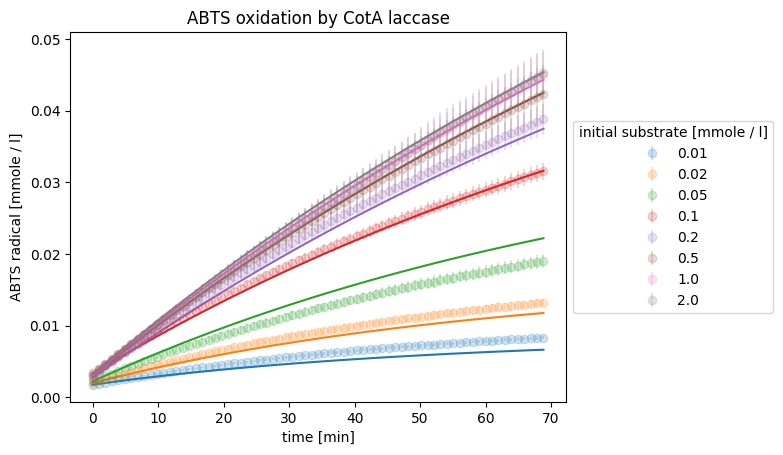

In [89]:
# Parameter estimation without time-dependent enzyme inactivation
CotA_kinetics = ParameterEstimator.from_EnzymeML(enzmldoc, "s1", "product")
CotA_kinetics.fit_models(enzyme_inactivation=False, display_output=False, stop_time_index=-1)
df = CotA_kinetics.result_dict.drop(columns=["kcat / Km [1/min * 1/mmole / l]"])
df.insert(1, "Enzyme inactivation model", "False")

# Parameter estimation considering time-dependent enzyme inactivation
CotA_kinetics_with_inactivation = ParameterEstimator.from_EnzymeML(enzmldoc, "s1", "product")
CotA_kinetics_with_inactivation.fit_models(enzyme_inactivation=True, display_output=False, stop_time_index=-1)
df_inactivation = CotA_kinetics_with_inactivation.result_dict.drop(columns=["kcat / Km [1/min * 1/mmole / l]"])
df_inactivation.insert(1, "Enzyme inactivation model", "True")

results = df.append(df_inactivation).sort_values("AIC")
display(results.style.set_table_attributes('style="font-size: 12px"'))

CotA_kinetics_with_inactivation.visualize("irreversible Michaelis Menten",alpha=0.2)

## Discussion